# Project 2
## General notes
Given two data sets:
- MNIST (same as from project 1). 
    - 9 classes, digits {-9, -2, 0, 1, 2, 5, 6, 8, 9}.
    - There are 2000 images of numbers.
    - Each image is 16x16. 
    - The data set has dimention 2000x256 (=51200). 
- Cats and Dogs data set.
    - 2 classes (binary), cats and dogs.
    - 99 images of cats and 99 images of dogs.
    - Each image is 64x64 (high-dimensional).
    - The data set has dimension 198x4096 (=811008).
    - OBS! THe given data set doesn't contain any labels as the MNIST data set does. The first 99 data points are cats and the lateral 99 data points are dogs.

In [1]:
# Import packages and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn functions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_classif
from sklearn.linear_model import Lasso

# Import data sets
MNIST = pd.read_csv('Numbers.txt', sep=r'\s+')
CATSDOGS = pd.read_csv('catdogdata.txt', sep=r'\s+')

### MNIST data set inspection


Number of data points: 2000
Image resolutions: 256

Frequency distribution:
Label -9: 189 samples
Label -2: 221 samples
Label 0: 349 samples
Label 1: 307 samples
Label 2: 200 samples
Label 5: 186 samples
Label 6: 201 samples
Label 8: 168 samples
Label 9: 179 samples


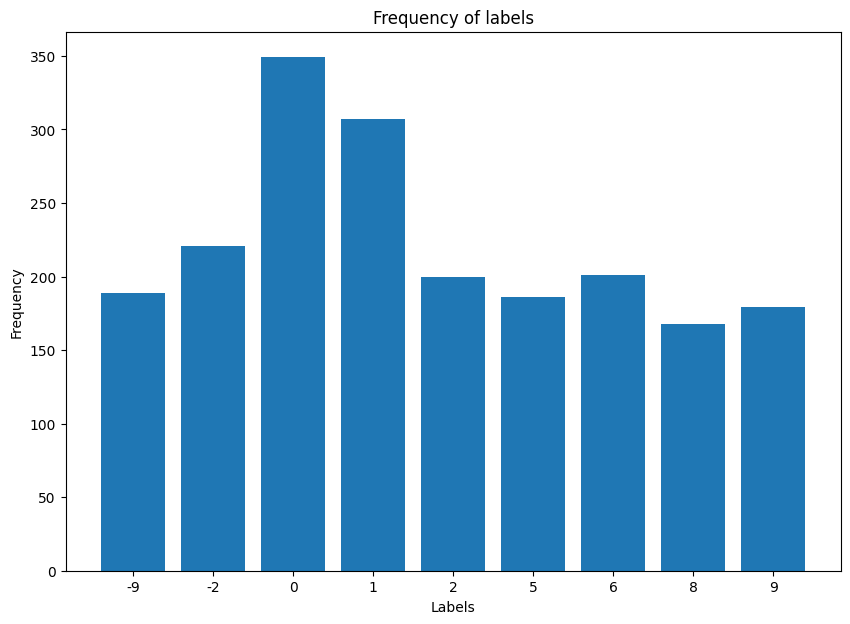

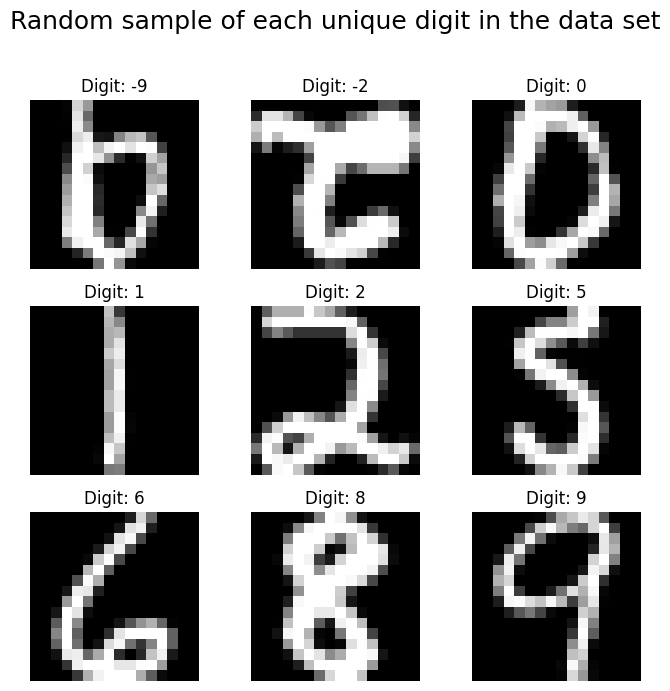

In [2]:
# Inspecting the MNIST data set, printing some observations and creating some 
# figures (from poject 1).

# Seperate labels from data
MNIST_labels = MNIST["V1"].values
MNIST_pixels = MNIST.iloc[:, 1:].values
print("\nNumber of data points: " + str(round(MNIST_pixels.shape[0])))
print("Image resolutions: " + str(round(MNIST_pixels.shape[1])))

# Print digit label distribution
print("\nFrequency distribution:")
MNIST_unique_labels, MNIST_counts = np.unique(MNIST_labels, return_counts=True)
for label, count in zip(MNIST_unique_labels, MNIST_counts):
    print("Label " + str(label) + ": " + str(count) + " samples")

# Define x positions
x_positions = np.arange(len(MNIST_unique_labels))
plt.figure(figsize=(10, 7))
plt.bar(x_positions, MNIST_counts)
plt.xticks(x_positions, MNIST_unique_labels)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Frequency of labels")
plt.show()

# Select one random example for each digit label
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.flatten()
indx = 0
for lab in MNIST_unique_labels:
    indices = np.where(MNIST_labels == lab)[0]
    random_index = np.random.choice(indices)
    pixels_index = MNIST_pixels[random_index]
    reshaped_data = pixels_index.reshape(16, 16)
    axes[indx].imshow(reshaped_data, cmap='gray', vmin=-1, vmax=1)
    axes[indx].set_title("Digit: " + str(lab))
    axes[indx].axis('off')
    indx = indx + 1

plt.tight_layout()
plt.suptitle(
    "Random sample of each unique digit in the data set", fontsize=18
)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

### Cats and Dogs data set inspection


Number of data points: 198
Image resolutions: 4096


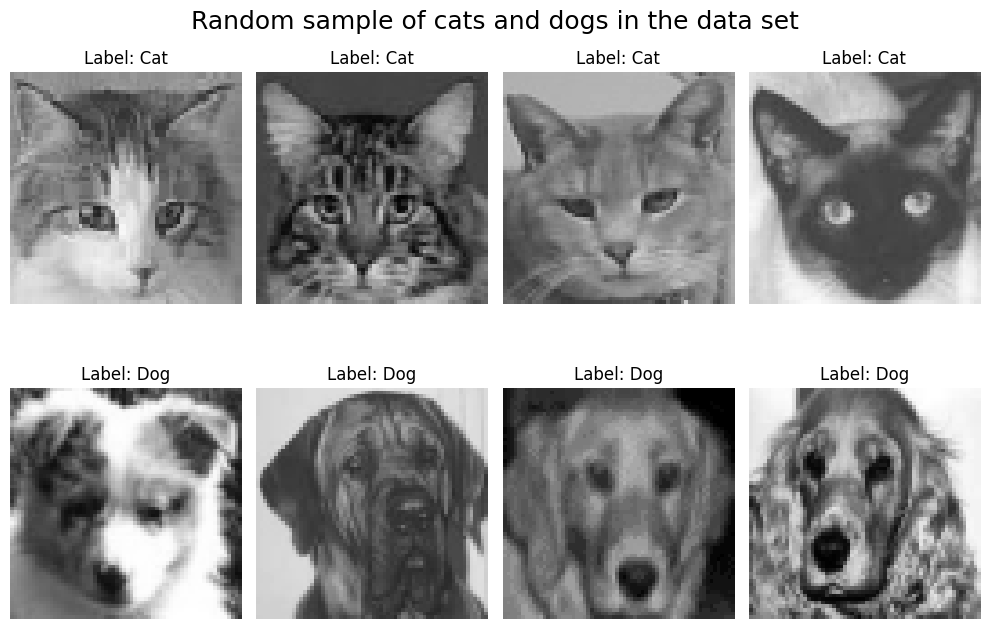

In [3]:
# Inspecting the cats and dogs data set, printing some observations and creating some 
# figures. The first 99 data points are cats and the lateral 99 data points are dogs.

# Seperate labels from data
CATSDOGS_labels = ["Cat"]*99 + ["Dog"]*99
CATSDOGS_pixels = CATSDOGS.iloc[:, :].values
print("\nNumber of data points: " + str(round(CATSDOGS_pixels.shape[0])))
print("Image resolutions: " + str(round(CATSDOGS_pixels.shape[1])))

# Plot 4 random cats and 4 random dogs
label_list = ["Cat"]*4 + ["Dog"]*4
fig, axes = plt.subplots(2, 4, figsize=(10, 7))
axes = axes.flatten()
indx = 0
for lab in label_list:
    indices = np.where([labels == lab for labels in CATSDOGS_labels])[0]
    random_index = np.random.choice(indices)
    pixels_index = CATSDOGS_pixels[random_index]
    reshaped_data = pixels_index.reshape(64, 64)
    reshaped_data = np.rot90(reshaped_data, k=-1)
    axes[indx].imshow(reshaped_data, cmap='gray', vmin=0, vmax=256)
    axes[indx].set_title("Label: " + str(lab))
    axes[indx].axis('off')
    indx = indx + 1

plt.tight_layout()
plt.suptitle(
    "Random sample of cats and dogs in the data set", fontsize=18
)
plt.show()

## Part 1
3 classifiers and 2 feature selection methods.
For each of the two data sets we want to answer,
1. Using cross-validation, determine how many features (pixels) you need for classification. Does the optimal number of features differ betweeen the approaches?
2. Which pixels are selected? Does this differ between approaches/classification methods? Why?
3. Repeat a couple of times, is the selection stable? Are the number of features needed and/or which pixels are chosen is roughly the same across multiple runs.

### Notes from lectures
Feature selection can be addressed in different ways:
- Pre-processing (filtering):
    - Crude, but fast
    - Typically only pays attention to one or two features at a time or does not take the outcome variable into consideration.
    - PCA, F-score, MIC.
- Wrapping:
    - Determine the best set of features by fitting models of different complexity and comparing their performance.
    - Best subset selection: Try all possible subsets of features and compare model performance with e.g. cross validation.
    - Forward selection: Start with just an intercept and add in each step the variable that improves the most (greedy algorithm).
    - Backward selection: Start with all variables and then remove the variable with the least impact (greedy algorithm).
    - Computationally very heavy
- Embeded:
    - Embed the feature selection into the model estimation procedure.
    - Ideally, penalization on the number of included features.
    - Lasso/elastic net.
    - Naive form is equally computationally heavy as wrapping

### Workflow
Classifiers:
1. Random Forest (RF)
2. Support Vector Machine (SVM)
3. Linear Regression (LR)

Feature Selection Method:
- Forward selection, F-test
- Lasso

### Feature Selection
#### MNIST: Forward selection with F-test

Classifier: Random Forest
Best score: 0.936

Classifier: SVM
Best score: 0.949

Classifier: Logistic Regression
Best score: 0.928



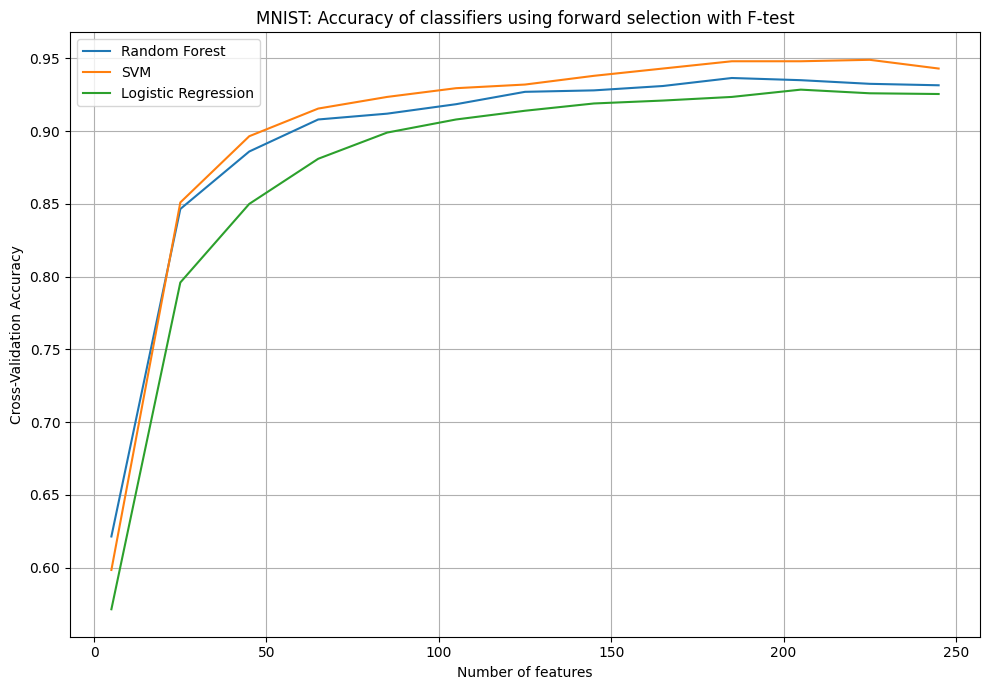

In [7]:
# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(
        max_depth=None, min_samples_split=2, n_estimators=200
    ),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(
        C=0.1, max_iter=5000
    )
}

number_of_splits = 5
cross_validation = StratifiedKFold(n_splits=number_of_splits, shuffle=True, random_state=1234)

selection_results = {
    "Random Forest": [],
    "SVM": [],
    "Logistic Regression": []
}

feature_range = np.arange(5, 256, 20)

for clf_name, clf in classifiers.items():
    print("Classifier: " + clf_name)
    for k in feature_range:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(score_func=f_classif, k=k)),
            ('classifier', clf)
        ])
        scores = cross_val_score(
            pipeline, MNIST_pixels, MNIST_labels, cv=cross_validation, scoring='accuracy'
        )
        selection_results[clf_name].append(scores.mean())
    print("Best score: " + str(round(max(selection_results[clf_name]), 3)))
    print()

plt.figure(figsize=(10, 7))
for clf_name, res in selection_results.items():
    plt.plot(feature_range, res, label = clf_name)
plt.title("MNIST: Accuracy of classifiers using forward selection with F-test")
plt.xlabel("Number of features")
plt.ylabel("Cross-Validation Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [14]:
number_of_features = { # Change number of features here based on previous cell
    "Random Forest": 200,
    "SVM": 200,
    "Logistic Regression": 200
}
number_of_runs = 10
number_of_splits = 5
selected_features_count = {
    "Random Forest": [0]*256,
    "SVM": [0]*256,
    "Logistic Regression": [0]*256
}

for r in range(number_of_runs):

    cross_validation = StratifiedKFold(
        n_splits=number_of_splits, shuffle=True, random_state=r
    )
    for clf_name, clf in classifiers.items():
        for train_idx, _ in cross_validation.split(MNIST_pixels, MNIST_labels):
            MNIST_pixels_train = MNIST_pixels[train_idx]
            MNIST_labels_train = [MNIST_labels[i] for i in train_idx]

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('selector', SelectKBest(score_func=f_classif, k=number_of_features[clf_name])),
                ('classifier', clf)
            ])
            pipeline.fit(MNIST_pixels_train, MNIST_labels_train)
            selector = pipeline.named_steps['selector']
            selected_features = selector.get_support(indices=True)
            for feat in selected_features:
                selected_features_count[clf_name][feat] += 1


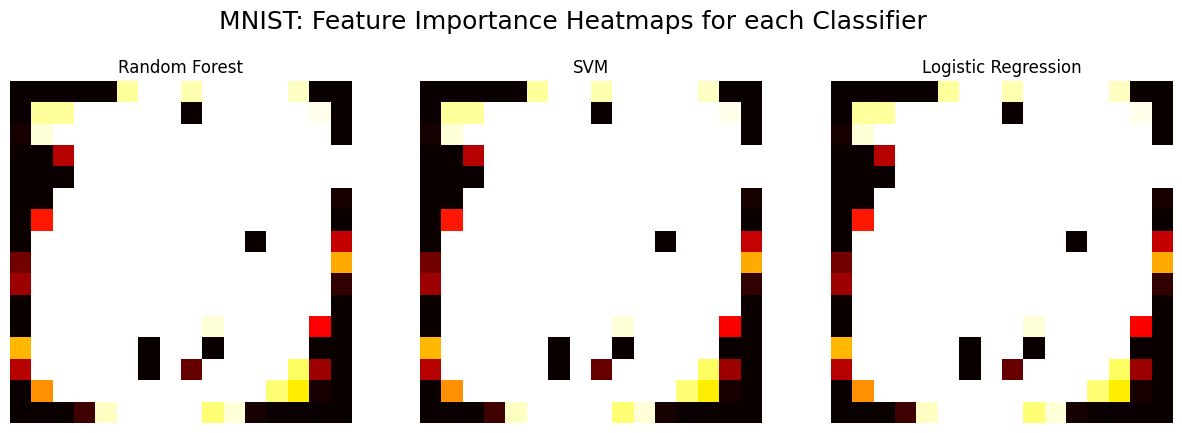

In [18]:
# Plot frequency of selected labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (clf_name, selected_features) in enumerate(selected_features_count.items()):
    pixel_importance = np.array(selected_features)
    pixel_importance = pixel_importance.reshape(16, 16)
    ax = axes[idx]
    im = ax.imshow(pixel_importance, cmap='hot')
    ax.set_title(clf_name)
    ax.axis('off')

fig.suptitle('MNIST: Feature Importance Heatmaps for each Classifier', fontsize=18)
plt.show()

#### Cats an Dogs: Forward selection with F-test

Classifier: Random Forest
Best score: 0.828

Classifier: SVM
Best score: 0.863

Classifier: Logistic Regression
Best score: 0.828



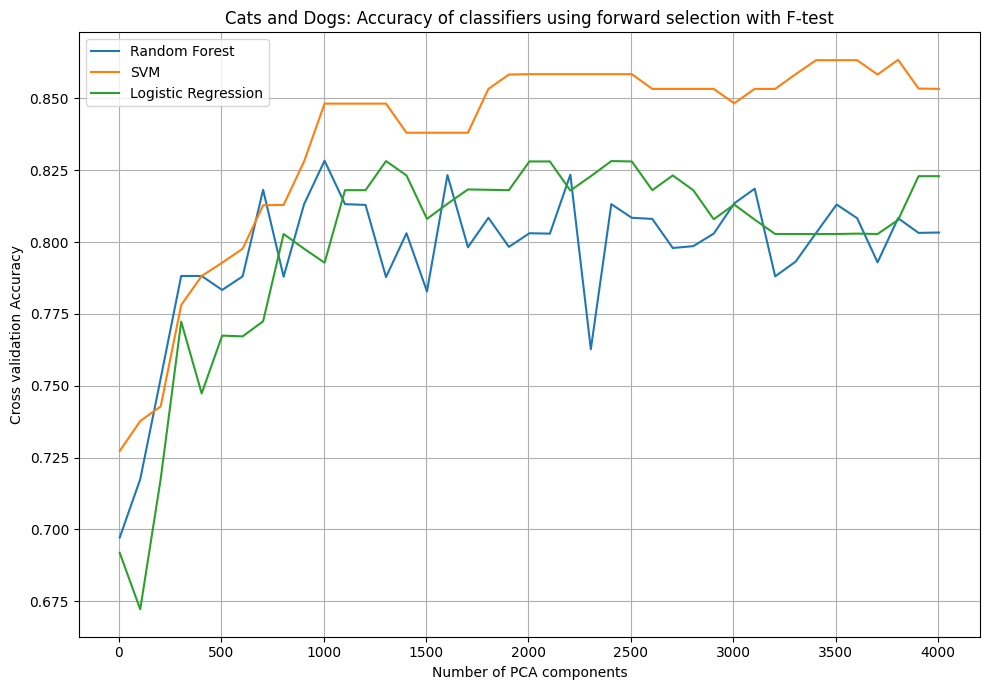

In [ ]:
# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=5000)
}

number_of_splits = 5
cross_validation = StratifiedKFold(n_splits=number_of_splits, shuffle=True, random_state=1234)

mean_scores = {
    "Random Forest": [],
    "SVM": [],
    "Logistic Regression": []
}

feature_range = np.arange(5, 4096, 100)

for clf_name, clf in classifiers.items():
    print("Classifier: " + clf_name)

    for k in feature_range:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(score_func=f_classif, k=k)),
            ('classifier', clf)
        ])
        scores = cross_val_score(
            pipeline, CATSDOGS_pixels, CATSDOGS_labels, 
            cv=cross_validation, scoring='accuracy'
        )
        mean_score = scores.mean()
        mean_scores[clf_name].append(mean_score)

    print("Best score: " + str(round(max(mean_scores[clf_name]), 3)))
    print()

plt.figure(figsize=(10, 7))
for clf_name, res in mean_scores.items():
    plt.plot(feature_range, res, label = clf_name)
plt.title("Cats and Dogs: Accuracy of classifiers using forward selection with F-test")
plt.xlabel("Number of features")
plt.ylabel("Cross validation Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [20]:
number_of_features = { # Change number of features here based on previous cell
    "Random Forest": 1000,
    "SVM": 1000,
    "Logistic Regression": 1000
}
number_of_runs = 10
number_of_splits = 5
selected_features_count = {
    "Random Forest": [0]*4096,
    "SVM": [0]*4096,
    "Logistic Regression": [0]*4096
}

for r in range(number_of_runs):

    cross_validation = StratifiedKFold(
        n_splits=number_of_splits, shuffle=True, random_state=r
    )
    for clf_name, clf in classifiers.items():
        for train_idx, _ in cross_validation.split(CATSDOGS_pixels, CATSDOGS_labels):
            CATSDOGS_pixels_train = CATSDOGS_pixels[train_idx]
            CATSDOGS_labels_train = [CATSDOGS_labels[i] for i in train_idx]

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('selector', SelectKBest(score_func=f_classif, k=number_of_features[clf_name])),
                ('classifier', clf)
            ])
            pipeline.fit(CATSDOGS_pixels_train, CATSDOGS_labels_train)
            selector = pipeline.named_steps['selector']
            selected_features = selector.get_support(indices=True)
            for feat in selected_features:
                selected_features_count[clf_name][feat] += 1


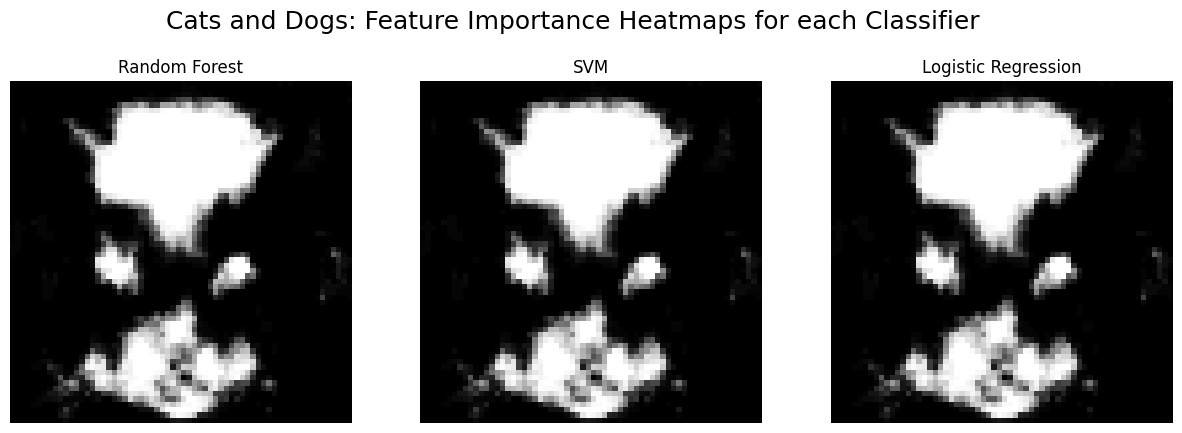

In [22]:
# Plot frequency of selected labels

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (clf_name, selected_features) in enumerate(selected_features_count.items()):
    pixel_importance = np.array(selected_features)
    pixel_importance = pixel_importance.reshape(64, 64)
    pixel_importance = np.rot90(pixel_importance, k=-1)
    ax = axes[idx]
    im = ax.imshow(pixel_importance, cmap='grey')
    ax.set_title(clf_name)
    ax.axis('off')

fig.suptitle('Cats and Dogs: Feature Importance Heatmaps for each Classifier', fontsize=18)
plt.show()

#### MNIST: Lasso

In [24]:
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC

# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(
        max_depth=None, min_samples_split=2, n_estimators=200
    ),
    "SVM": LinearSVC(),
    "Logistic Regression": LogisticRegression(
        C=0.1, max_iter=5000
    )
}

number_of_splits = 5

# Lasso
lasso = LassoCV(cv=number_of_splits, random_state=123)
lasso.fit(MNIST_pixels, MNIST_labels)
selected_features = np.where(lasso.coef_ != 0)[0]
MNIST_pixels_lasso = MNIST_pixels[:, selected_features]
selection_results = {
    "Random Forest": [],
    "SVM": [],
    "Logistic Regression": []
}

cross_validation = StratifiedKFold(n_splits=number_of_splits, shuffle=True, random_state=123)
for clf_name, clf in classifiers.items():
    print("Classifier: " + clf_name)
    scores = cross_val_score(
        clf, MNIST_pixels_lasso, MNIST_labels, cv=cross_validation, scoring='accuracy'
    )
    selection_results[clf_name].append(scores.mean())
    print("Best score: " + str(round(max(selection_results[clf_name]), 3)))
    print()

Classifier: Random Forest
Best score: 0.92

Classifier: SVM
Best score: 0.895

Classifier: Logistic Regression
Best score: 0.916



#### Cats and Dogs: Lasso

In [27]:
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC

# Classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(
        max_depth=None, min_samples_split=2, n_estimators=200
    ),
    "SVM": LinearSVC(),
    "Logistic Regression": LogisticRegression()
}

# Lasso
CATSDOGS_binary_labels = [0 if label == "CAT" else 1 for label in CATSDOGS_labels]
number_of_splits = 5
lasso = LassoCV(cv=number_of_splits, random_state=123)
lasso.fit(CATSDOGS_pixels, CATSDOGS_binary_labels)
selected_features = np.where(lasso.coef_ != 0)[0]
CATSDOGS_pixels_lasso = CATSDOGS_pixels[:, selected_features]
selection_results = {
    "Random Forest": [],
    "SVM": [],
    "Logistic Regression": []
}

cross_validation = StratifiedKFold(n_splits=number_of_splits, shuffle=True, random_state=123)
for clf_name, clf in classifiers.items():
    print("Classifier: " + clf_name)
    scores = cross_val_score(
        clf, CATSDOGS_pixels_lasso, CATSDOGS_binary_labels, cv=cross_validation, scoring='accuracy'
    )
    selection_results[clf_name].append(scores.mean())
    print("Best score: " + str(round(max(selection_results[clf_name]), 3)))
    print()

c:\Users\carl0\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\carl0\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


KeyboardInterrupt: 

Classifier: Random Forest


c:\Users\carl0\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\carl0\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


KeyboardInterrupt: 

## Part 2